In [1]:
from analysis_helpers import *
import pylab as plt

%matplotlib qt

folder = r'E:/CSHL/pita_g0/ks25'

spike_times_samples,spike_clusters,spike_amplitudes,spike_positions,templates_raw,templates_position,cluster_groups = load_phy_folder(folder)

In [2]:
# the spikes need to be converted to time (they are in samples now)
# we do this by dividing by the sampling rate
# lets load the sampling rate from the file we saved earlier

syncs = glob(pjoin(folder,'..','experiment_syncs.h5'))[0]
import h5py as h5

with h5.File(syncs,'r') as fd:
    srate = fd['sampling_rate'][()]
    visual_onsets = fd['visual_sync_s'][()]
    opto_onsets = fd['opto_sync_s'][()]
spike_times = spike_times_samples/srate



In [22]:
# load trial information
stimlog = pd.read_csv(glob(pjoin(folder,'..','logs','*.gratings.csv'))[0]) # this has the orientations
optolog = pd.read_csv(glob(pjoin(folder,'..','logs','*.gratings.opto.log'))[0]) # this has the orientations


Text(0, 0.5, 'Number of trials')

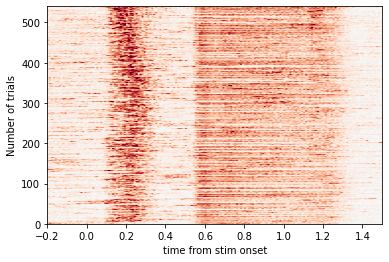

In [106]:
# lets plot a population PSTH of good units
# lets do this only for good units
cluster_ids = cluster_groups.cluster_id[cluster_groups.group == 'good'].values
selection = np.isin(spike_clusters,cluster_ids)

binsize = 0.01 # lets use a 10ms binsize
edges = np.arange(0,np.max(spike_times[selection]),binsize)

pop_rate,_ = np.histogram(spike_times[selection],edges)
pop_rate = pop_rate/binsize
pop_rate_time = edges[:-1]+np.diff(edges[:2])/2

psth = []
tpre = 0.2
tpost = 1.5
 
for onset in visual_onsets:
    psth.append(pop_rate[(pop_rate_time>= onset -tpre) & (pop_rate_time< onset +tpost)])
psth = np.stack(psth)
plt.figure()
plt.imshow(psth,aspect='auto',extent=[-tpre,tpost,0,len(psth)],cmap = 'RdBu_r',clim = [-1000,1000])
plt.xlabel('time from stim onset')
plt.ylabel('Number of trials')

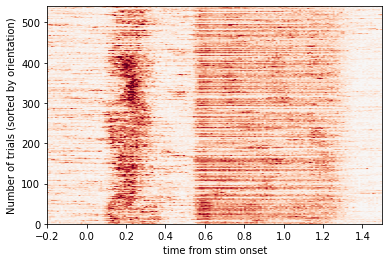

In [107]:
# sort by orientation
plt.imshow(psth[np.argsort(stimlog.ori)],
           aspect='auto',
           extent=[-tpre,tpost,0,len(psth)],
           cmap = 'RdBu_r',
           clim = [-1000,1000])
plt.xlabel('time from stim onset')
plt.ylabel('Number of trials (sorted by orientation)');

In [102]:
# now lets plot rasters for single cells. 
cluster_ids = cluster_groups.cluster_id[cluster_groups.group == 'good'].values
selection = np.isin(spike_clusters,cluster_ids)

clus = spike_clusters[selection]
# separate the spikes from each unit
timestamps = [spike_times[selection][clus == uclu] for uclu in np.unique(clus)]

trig_ts = []
for sp in timestamps:
    trig_ts.append([])
    for o in visual_onsets:
        trig_ts[-1].append(sp[(sp>=(o-tpre)) & (sp<(o+tpost))] - o)

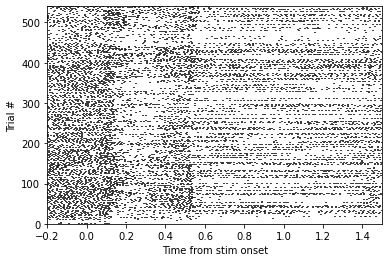

In [105]:
# plot the raster for a single units
iunit = 21
for i,ss in enumerate(trig_ts[iunit]):
    plt.vlines(ss,i,i+1,color = 'k')
plt.xlim([-tpre,tpost])
plt.ylim([0,len(stimlog)])
plt.ylabel('Trial #')
plt.xlabel('Time from stim onset');

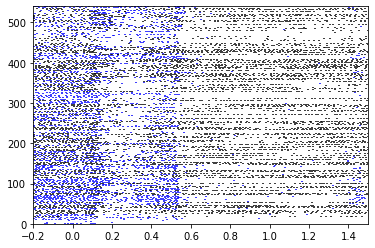

In [100]:
# show the opto trials in different color
# plot the raster for a single units
iunit = 21
plt.figure()
triggered_spikes = trig_ts[iunit]
for i,ss in enumerate(triggered_spikes):
    color = 'black'
    if optolog.iloc[i].has_opto:
        color = 'blue'
    plt.vlines(ss,i,i+1,color = color)
plt.xlim([-tpre,tpost])
plt.ylim([0,len(stimlog)]);

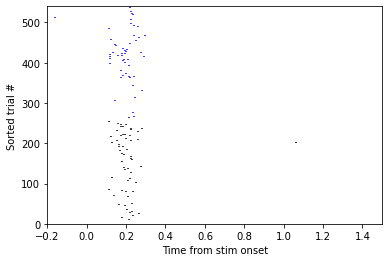

In [109]:
# It is hard to see if units are supressed or not like that, lets sort the trials by opto or no opto
iunit = 41
%matplotlib inline
plt.figure()
sel = np.argsort(optolog.has_opto)
triggered_spikes = [trig_ts[iunit][i] for i in sel] # arange the trials

for i,ss in enumerate(triggered_spikes):
    color = 'black'
    if optolog.iloc[sel].iloc[i].has_opto:
        color = 'blue'
    plt.vlines(ss,i,i+1,color = color)
plt.xlim([-tpre,tpost])
plt.ylim([0,len(stimlog)])
plt.ylabel('Sorted trial #')
plt.xlabel('Time from stim onset');